<a href="https://colab.research.google.com/github/MayerT1/Prep_GEDI/blob/main/Sewanee_Field_Campaign_Canopy_Cover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


CANOPY COVER ANALYSIS

Found 11 images to process

Processing: Canopy_site_16.jpg
  Saved analysis to: /content/drive/MyDrive/PhD_Main_Folder/Field_data/Sewanee_Field_Campaign_Fall_2025/Canopy_Photos/canopy_analysis_output/Canopy_site_16_analysis.png
Processing: Canopy_site_25.jpg
  Saved analysis to: /content/drive/MyDrive/PhD_Main_Folder/Field_data/Sewanee_Field_Campaign_Fall_2025/Canopy_Photos/canopy_analysis_output/Canopy_site_25_analysis.png
Processing: Canopy_site_27.jpg
  Saved analysis to: /content/drive/MyDrive/PhD_Main_Folder/Field_data/Sewanee_Field_Campaign_Fall_2025/Canopy_Photos/canopy_analysis_output/Canopy_site_27_analysis.png
Processing: Canopy_site_29.jpg
  Saved analysis to: /content/drive/MyDrive/PhD_Main_Folder/Field_data/Sewanee_Field_Campaign_Fall_2025/Canopy_Photos/canopy_analysis_output/Canopy_site_29_analysis.png
Processing: Canopy_site_41.jpg
  Saved analysis to: /content/drive/MyDrive/PhD_Main_Folder/Field_data/Sewanee_Field_Campaign_Fall_2025/Canopy_Photos/

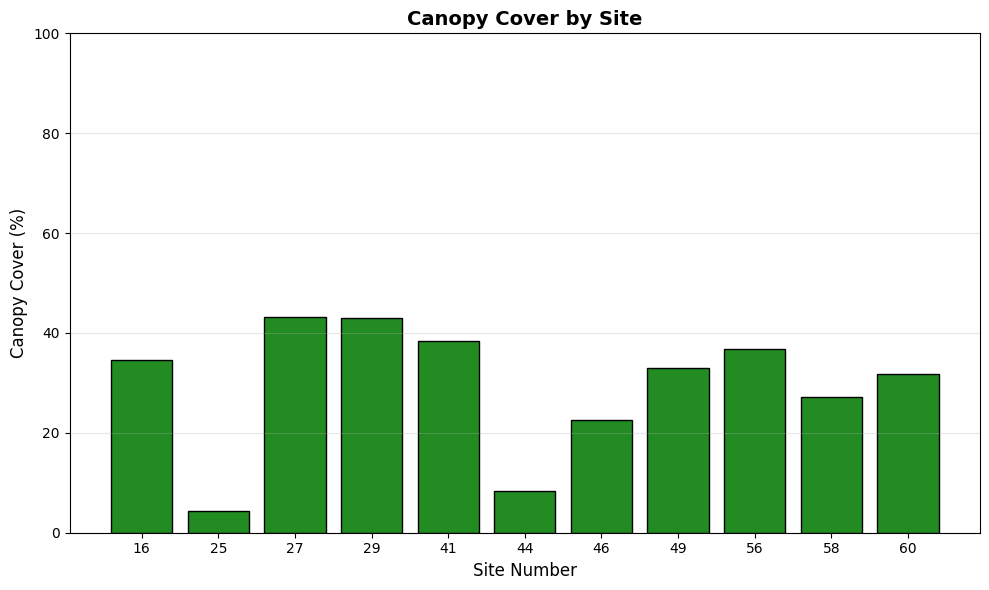


ANALYSIS COMPLETE!


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from pathlib import Path

class CanopyCoverAnalyzer:
    """
    Analyzes fisheye canopy images to calculate canopy cover percentage
    and generate classification masks (sky, vegetation, background)
    """

    def __init__(self, image_folder):
        self.image_folder = image_folder
        self.results = []

    def load_image(self, filepath):
        """Load image using OpenCV"""
        img = cv2.imread(filepath)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img_rgb

    def apply_circular_mask(self, img):
        """Apply circular mask to focus on fisheye circular region"""
        h, w = img.shape[:2]
        center = (w // 2, h // 2)
        radius = min(center[0], center[1]) - 10  # Slightly smaller than image

        # Create circular mask
        Y, X = np.ogrid[:h, :w]
        dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
        mask = dist_from_center <= radius

        return mask

    def classify_pixels(self, img, mask):
        """
        Classify pixels into sky (open), vegetation (canopy), and background
        Uses blue/red ratio and brightness thresholding
        """
        h, w = img.shape[:2]

        # Convert to different color spaces for better classification
        img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

        # Extract channels
        r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
        h_channel, s_channel, v_channel = img_hsv[:,:,0], img_hsv[:,:,1], img_hsv[:,:,2]
        l_channel, a_channel, b_lab = img_lab[:,:,0], img_lab[:,:,1], img_lab[:,:,2]

        # Initialize classification mask
        # 0 = background, 1 = vegetation, 2 = sky
        classification = np.zeros((h, w), dtype=np.uint8)

        # Sky detection: high brightness, high blue, low saturation
        sky_mask = (
            (v_channel > 150) &  # Bright
            (b > r * 1.1) &      # More blue than red
            (b > g * 0.9) &      # Blue dominant
            (s_channel < 100) &  # Low saturation
            mask                 # Within circular region
        )

        # Vegetation detection: green dominant, moderate saturation
        # Use excess green index
        excess_green = 2 * g.astype(float) - r.astype(float) - b.astype(float)

        vegetation_mask = (
            (excess_green > 20) &     # Green dominant
            (s_channel > 30) &        # Some saturation
            (v_channel < 200) &       # Not too bright
            (a_channel < 128) &       # Negative 'a' in LAB (greenish)
            mask &                    # Within circular region
            (~sky_mask)               # Not already classified as sky
        )

        # Apply Otsu's thresholding as additional refinement
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        _, otsu_thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Refine sky mask with Otsu
        sky_mask = sky_mask | ((otsu_thresh > 127) & mask & (~vegetation_mask))

        # Assign classifications
        classification[vegetation_mask] = 1  # Vegetation
        classification[sky_mask] = 2         # Sky

        return classification

    def calculate_canopy_cover(self, classification, mask):
        """
        Calculate canopy cover percentage
        Canopy cover = (vegetation pixels / total valid pixels) * 100
        """
        valid_pixels = np.sum(mask)
        vegetation_pixels = np.sum(classification == 1)
        sky_pixels = np.sum(classification == 2)

        # Canopy cover is the percentage of vegetation in the valid area
        canopy_cover = (vegetation_pixels / valid_pixels) * 100 if valid_pixels > 0 else 0

        return canopy_cover, vegetation_pixels, sky_pixels, valid_pixels

    def create_visualization_masks(self, img, classification, mask):
        """Create colored visualization masks"""
        h, w = img.shape[:2]

        # Create RGB mask
        viz_mask = np.zeros((h, w, 3), dtype=np.uint8)
        viz_mask[classification == 0] = [128, 128, 128]  # Background - gray
        viz_mask[classification == 1] = [0, 255, 0]      # Vegetation - green
        viz_mask[classification == 2] = [135, 206, 235]  # Sky - sky blue

        # Make background areas outside circle black
        viz_mask[~mask] = [0, 0, 0]

        return viz_mask

    def process_image(self, filepath, save_masks=True):
        """Process a single image"""
        print(f"Processing: {os.path.basename(filepath)}")

        # Load image
        img = self.load_image(filepath)

        # Apply circular mask
        circular_mask = self.apply_circular_mask(img)

        # Classify pixels
        classification = self.classify_pixels(img, circular_mask)

        # Calculate canopy cover
        canopy_cover, veg_px, sky_px, total_px = self.calculate_canopy_cover(
            classification, circular_mask
        )

        # Create visualization
        viz_mask = self.create_visualization_masks(img, classification, circular_mask)

        # Extract site number from filename
        filename = os.path.basename(filepath)
        site_num = ''.join(filter(str.isdigit, filename))

        # Save results
        result = {
            'filename': filename,
            'site_number': site_num,
            'canopy_cover_percent': round(canopy_cover, 2),
            'vegetation_pixels': int(veg_px),
            'sky_pixels': int(sky_px),
            'total_valid_pixels': int(total_px),
            'filepath': filepath
        }

        self.results.append(result)

        # Save masks if requested
        if save_masks:
            self.save_masks(filepath, img, viz_mask, classification, canopy_cover)

        return result, viz_mask, classification

    def save_masks(self, filepath, original, viz_mask, classification, canopy_cover):
        """Save mask images"""
        base_name = os.path.splitext(os.path.basename(filepath))[0]
        output_dir = os.path.join(os.path.dirname(filepath), 'canopy_analysis_output')
        os.makedirs(output_dir, exist_ok=True)

        # Create composite visualization
        fig, axes = plt.subplots(2, 2, figsize=(12, 12))

        # Original image
        axes[0, 0].imshow(original)
        axes[0, 0].set_title('Original Image')
        axes[0, 0].axis('off')

        # Classification overlay
        overlay = original.copy()
        overlay[classification == 1] = [0, 255, 0]  # Green for vegetation
        overlay[classification == 2] = [135, 206, 235]  # Blue for sky
        axes[0, 1].imshow(overlay)
        axes[0, 1].set_title('Classification Overlay')
        axes[0, 1].axis('off')

        # Vegetation mask only
        veg_only = np.zeros_like(original)
        veg_only[classification == 1] = [0, 255, 0]
        axes[1, 0].imshow(veg_only)
        axes[1, 0].set_title('Vegetation Mask')
        axes[1, 0].axis('off')

        # Sky mask only
        sky_only = np.zeros_like(original)
        sky_only[classification == 2] = [135, 206, 235]
        axes[1, 1].imshow(sky_only)
        axes[1, 1].set_title('Sky Mask')
        axes[1, 1].axis('off')

        plt.suptitle(f'{base_name}\nCanopy Cover: {canopy_cover:.2f}%',
                     fontsize=14, fontweight='bold')
        plt.tight_layout()

        # Save figure
        output_path = os.path.join(output_dir, f'{base_name}_analysis.png')
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        plt.close()

        # Save individual masks as numpy arrays
        np.save(os.path.join(output_dir, f'{base_name}_classification.npy'), classification)

        print(f"  Saved analysis to: {output_path}")

    def process_all_images(self, save_masks=True):
        """Process all images in the folder"""
        # Find all jpg images
        image_files = sorted(Path(self.image_folder).glob('*.jpg'))
        image_files += sorted(Path(self.image_folder).glob('*.JPG'))

        print(f"Found {len(image_files)} images to process\n")

        for img_path in image_files:
            self.process_image(str(img_path), save_masks=save_masks)

        # Create summary dataframe
        df = pd.DataFrame(self.results)
        df = df.sort_values('site_number')

        return df

    def save_summary(self, df, output_path=None):
        """Save summary results to CSV"""
        if output_path is None:
            output_path = os.path.join(self.image_folder, 'canopy_analysis_output',
                                      'canopy_cover_summary.csv')

        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        df.to_csv(output_path, index=False)
        print(f"\nSummary saved to: {output_path}")

        return output_path


# ============= MAIN EXECUTION =============

# Set your image folder path
IMAGE_FOLDER = '/content/drive/MyDrive/PhD_Main_Folder/Field_data/Sewanee_Field_Campaign_Fall_2025/Canopy_Photos'

# Create analyzer instance
analyzer = CanopyCoverAnalyzer(IMAGE_FOLDER)

# Process all images
print("="*60)
print("CANOPY COVER ANALYSIS")
print("="*60 + "\n")

results_df = analyzer.process_all_images(save_masks=True)

# Save summary
analyzer.save_summary(results_df)

# Display summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"\nTotal images processed: {len(results_df)}")
print(f"Mean canopy cover: {results_df['canopy_cover_percent'].mean():.2f}%")
print(f"Std deviation: {results_df['canopy_cover_percent'].std():.2f}%")
print(f"Min canopy cover: {results_df['canopy_cover_percent'].min():.2f}%")
print(f"Max canopy cover: {results_df['canopy_cover_percent'].max():.2f}%")

print("\n" + "="*60)
print("INDIVIDUAL SITE RESULTS")
print("="*60)
print(results_df[['site_number', 'canopy_cover_percent']].to_string(index=False))

# Create summary plot
plt.figure(figsize=(10, 6))
plt.bar(results_df['site_number'].astype(str), results_df['canopy_cover_percent'],
        color='forestgreen', edgecolor='black')
plt.xlabel('Site Number', fontsize=12)
plt.ylabel('Canopy Cover (%)', fontsize=12)
plt.title('Canopy Cover by Site', fontsize=14, fontweight='bold')
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

summary_plot_path = os.path.join(IMAGE_FOLDER, 'canopy_analysis_output',
                                 'canopy_cover_summary_plot.png')
plt.savefig(summary_plot_path, dpi=150, bbox_inches='tight')
print(f"\nSummary plot saved to: {summary_plot_path}")
plt.show()

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)